# Разработка алгоритма прогнозирования ценовых движений на финансовом рынке

### Описание задачи:
Участникам предлагается разработать алгоритм-индикатор, который 
прогнозирует краткосрочные ценовые изменения выбранного финансового 
инструмента. Основная цель — предсказать направление (рост, падение или 
стабильность) цены на 15-минутный временной интервал с максимально 
возможной точностью. Модель должна генерировать рекомендации по 
уровням stop-loss и take-profit для каждой сделки.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

In [2]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, f1_score

### Исходные данные 
Финансовый рынок: исторические данные о ценах (OHLC : Open, High, 
Low, Close) для конкретного актива в конкретный момент времени. Всего 
тестовых активов 10 штук.Интервалы времени: данные предоставляются в таймфрейме 15-минут.

Здесь работа проделана только с одним активом. Сначала модель разрабатывалась на тестовых данных, затем проверялось все на боевых данных.

In [4]:
df = pd.read_csv('PENDLE_USDT_15m_candles.csv', sep=';')
df

,timestamp,open,high,low,close
0,2023-07-03 10:00:00,0.7796,1.2900,0.7796,1.1338
1,2023-07-03 10:15:00,1.1332,1.1466,1.0200,1.0500
2,2023-07-03 10:30:00,1.0482,1.0598,0.9700,0.9740
3,2023-07-03 10:45:00,0.9730,1.0335,0.9650,0.9982
4,2023-07-03 11:00:00,0.9992,1.0170,0.9820,0.9998
...,...,...,...,...,...
26993,2024-04-09 14:15:00,6.2485,6.2671,6.2000,6.2101
26994,2024-04-09 14:30:00,6.2107,6.2276,6.1509,6.1700
26995,2024-04-09 14:45:00,6.1688,6.1994,6.1000,6.1721
26996,2024-04-09 15:00:00,6.1717,6.2067,6.0739,6.1570


#### Данные предобработаны, добавлены факторы и индикаторы

In [232]:
df_train = pd.read_csv('PENDLE_USDT.csv', sep=';') # исходные данные
df_test = pd.read_csv('PENDLE_USDT_test.csv', sep=';') # боевые данные
df_test

,Unnamed: 0,open,high,low,close,atr5,returns,range_pct,sma_200,sma5_signal,sma10_signal,sma20_signal,sma40_signal,sma80_signal,rsi5,rsi10,rsi40,rev,mom,SMA_delta
0,200,6.9864,6.9880,6.9051,6.9343,0.117198,0.992770,0.021003,6.804773,1.0,1.0,1.0,1.0,1.0,20.483733,19.073886,37.970728,-0.000229,0.007141,-0.465137
1,201,6.9350,6.9467,6.9096,6.9227,0.091999,0.998327,0.011955,6.807858,0.0,0.0,0.0,0.0,0.0,24.735074,13.599545,38.085551,-0.000101,-0.007485,-0.443641
2,202,6.9218,6.9218,6.8500,6.8561,0.079166,0.990379,0.005359,6.810694,0.0,0.0,0.0,0.0,0.0,53.885135,14.245311,37.192227,0.000130,-0.001775,-0.419722
3,203,6.8550,6.8550,6.8112,6.8348,0.057844,0.996893,0.010472,6.813279,0.0,0.0,0.0,0.0,0.0,25.339367,13.505504,32.217032,0.000160,-0.009537,-0.392316
4,204,6.8350,6.8997,6.8132,6.8987,0.068063,1.009349,0.006408,6.816242,0.0,0.0,0.0,0.0,0.0,25.149701,13.636364,32.487655,-0.000029,-0.002951,-0.363836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27244,27444,3.9450,3.9680,3.8890,3.9080,0.066314,0.991124,0.030941,3.938615,0.0,0.0,0.0,0.0,0.0,36.263736,34.670487,59.549746,-0.000507,-0.007580,-0.096040
27245,27445,3.9120,3.9610,3.9090,3.9300,0.068209,1.005629,0.020215,3.938155,0.0,0.0,0.0,0.0,0.0,14.689266,27.548209,60.471976,-0.001023,-0.009423,-0.094735
27246,27446,3.9340,3.9630,3.9050,3.9500,0.063473,1.005089,0.013232,3.937875,0.0,0.0,0.0,0.0,0.0,12.716763,25.071225,61.775495,-0.001017,0.004591,-0.092695
27247,27447,3.9520,3.9870,3.9390,3.9510,0.069649,1.000253,0.014684,3.937485,0.0,0.0,0.0,0.0,0.0,22.222222,32.238806,61.549815,-0.000506,0.004059,-0.088425


#### Сведение задачи к бинарной классификации: рост или спад цены актива

In [234]:
df_train['prev_close'] = df_train['close'].shift(periods=[-1])
df_train['new_target'] = df_train['close'] > df_train['prev_close']

In [235]:
df_test['prev_close'] = df_test['close'].shift(periods=[-1])
df_test['new_target'] = df_test['close'] > df_test['prev_close']

In [236]:
df_train['new_target'] = df_train['new_target'].map({True: 1, False: 0})
df_test['new_target'] = df_test['new_target'].map({True: 1, False: 0})

In [237]:
df_train

,Unnamed: 0,open,high,low,close,atr5,returns,range_pct,sma_200,sma5_signal,...,sma40_signal,sma80_signal,rsi5,rsi10,rsi40,rev,mom,SMA_delta,prev_close,new_target
0,200,0.8601,0.8736,0.8561,0.8568,0.018697,0.996279,0.021512,0.895271,0.0,...,0.0,1.0,70.025189,48.855989,38.872651,-0.000116,0.014052,0.034100,0.8552,1
1,201,0.8570,0.8583,0.8500,0.8552,0.013198,0.998133,0.020425,0.894297,0.0,...,0.0,0.0,69.500000,47.889182,39.769329,-0.000233,-0.003844,0.034285,0.8511,1
2,202,0.8550,0.8550,0.8501,0.8511,0.010466,0.995206,0.009705,0.893682,0.0,...,0.0,0.0,57.142857,49.120433,37.483560,0.000234,-0.002103,0.034451,0.8554,0
3,203,0.8511,0.8730,0.8510,0.8554,0.014610,1.005052,0.005757,0.892968,0.0,...,0.0,0.0,40.133779,48.400000,37.303665,-0.000000,-0.004572,0.034897,0.8553,1
4,204,0.8554,0.8585,0.8525,0.8553,0.012240,0.999883,0.025719,0.892245,0.0,...,0.0,0.0,64.682540,45.338983,38.941891,-0.000000,0.005040,0.035008,0.8488,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26793,26993,6.2485,6.2671,6.2000,6.2101,0.086768,0.994189,0.015001,6.559809,0.0,...,0.0,0.0,58.993399,57.165396,32.461886,-0.000336,0.012631,0.350173,6.1700,1
26794,26994,6.2107,6.2276,6.1509,6.1700,0.067845,0.993543,0.010805,6.557862,0.0,...,0.0,0.0,54.517728,52.985620,33.273158,-0.000097,-0.006164,0.355254,6.1721,0
26795,26995,6.1688,6.1994,6.1000,6.1721,0.061397,1.000340,0.012431,6.555455,0.0,...,0.0,0.0,32.742616,48.678907,30.643149,0.000195,-0.006575,0.361942,6.1570,1
26796,26996,6.1717,6.2067,6.0739,6.1570,0.076498,0.997554,0.016105,6.552857,0.0,...,0.0,0.0,38.225420,55.527448,33.004746,0.000065,0.000535,0.366975,6.1152,1


In [239]:
f = ['open', 'high', 'low', 'close','atr5', 'returns',
       'range_pct', 'sma_200', 'sma5_signal', 'sma10_signal', 'sma20_signal',
       'sma40_signal', 'sma80_signal', 'rsi5', 'rsi10', 'rsi40', 'rev', 'mom',
       'SMA_delta', 'prev_close']

In [240]:
X_train = df_train[f]
X_test = df_test[f]

y_train = df_train['new_target']
y_test = df_test['new_target']

In [241]:
# нормализация
col_norms = dict()
for col in X_train.columns:
    X_train[col+'_norm'] = (X_train[col] -X_train[col].min())/(X_train[col].max()-X_train[col].min())
    col_norms[col] = [X_train[col].min(), X_train[col].max()]

for col in X_test.columns:
    X_test[col+'_norm'] = (X_test[col] -col_norms[col][0])/(col_norms[col][1]-col_norms[col][0])

C:\Users\Liza\AppData\Local\Temp\ipykernel_15812\2321560923.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col+'_norm'] = (X_train[col] -X_train[col].min())/(X_train[col].max()-X_train[col].min())
C:\Users\Liza\AppData\Local\Temp\ipykernel_15812\2321560923.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col+'_norm'] = (X_test[col] -col_norms[col][0])/(col_norms[col][1]-col_norms[col][0])


In [242]:
X_train.columns

Index(['open', 'high', 'low', 'close', 'atr5', 'returns', 'range_pct',
       'sma_200', 'sma5_signal', 'sma10_signal', 'sma20_signal',
       'sma40_signal', 'sma80_signal', 'rsi5', 'rsi10', 'rsi40', 'rev', 'mom',
       'SMA_delta', 'prev_close', 'open_norm', 'high_norm', 'low_norm',
       'close_norm', 'atr5_norm', 'returns_norm', 'range_pct_norm',
       'sma_200_norm', 'sma5_signal_norm', 'sma10_signal_norm',
       'sma20_signal_norm', 'sma40_signal_norm', 'sma80_signal_norm',
       'rsi5_norm', 'rsi10_norm', 'rsi40_norm', 'rev_norm', 'mom_norm',
       'SMA_delta_norm', 'prev_close_norm'],
      dtype='object')

In [243]:
X_train = X_train.drop(columns=['open_norm', 'high_norm', 'low_norm', 'close_norm','atr5', 'returns',
       'range_pct', 'sma_200', 'sma5_signal', 'sma10_signal', 'sma20_signal',
       'sma40_signal', 'sma80_signal', 'rsi5', 'rsi10', 'rsi40', 'rev', 'mom',
       'SMA_delta', 'prev_close'])
X_test = X_test.drop(columns=['open_norm', 'high_norm', 'low_norm', 'close_norm','atr5', 'returns',
       'range_pct', 'sma_200', 'sma5_signal', 'sma10_signal', 'sma20_signal',
       'sma40_signal', 'sma80_signal', 'rsi5', 'rsi10', 'rsi40', 'rev', 'mom',
       'SMA_delta', 'prev_close'])

In [244]:
X_test.columns

Index(['open', 'high', 'low', 'close', 'atr5_norm', 'returns_norm',
       'range_pct_norm', 'sma_200_norm', 'sma5_signal_norm',
       'sma10_signal_norm', 'sma20_signal_norm', 'sma40_signal_norm',
       'sma80_signal_norm', 'rsi5_norm', 'rsi10_norm', 'rsi40_norm',
       'rev_norm', 'mom_norm', 'SMA_delta_norm', 'prev_close_norm'],
      dtype='object')

#### Обучение модели XGBoost

In [263]:
model = XGBClassifier(objective='binary:logistic', 
                      eval_metric='auc',       #logloss
                      random_state=88,
                      n_estimators = 1000, # n_estimators = 15, 
                      reg_alpha=2,
                      max_depth = 5, #subsample = 0.8,
                      learning_rate = 0.05
                     )
model.fit(X_train, y_train)

# Предсказания
y_pred_train = model.predict(X_train)
y_pred_proba_train = model.predict_proba(X_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Оценка модели
#print("Classification Report TRAIN:")
#print(classification_report(y_train, y_pred_train))

print("Classification Report TEST:")
print(classification_report(y_test, y_pred))

Classification Report TEST:
              precision    recall  f1-score   support

           0       0.55      0.64      0.59     13635
           1       0.57      0.48      0.52     13614

    accuracy                           0.56     27249
   macro avg       0.56      0.56      0.56     27249
weighted avg       0.56      0.56      0.56     27249



#### Цель была перейти за порог 50% по каждому из классов (здесь по f1-score выполнено)

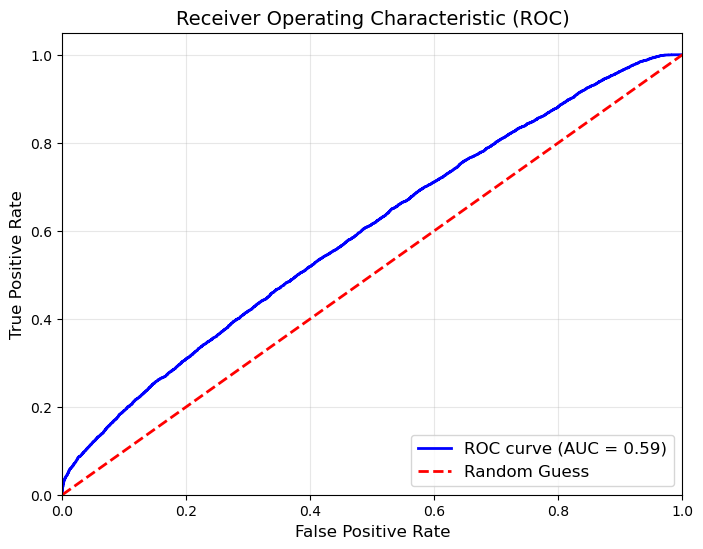

In [264]:
y_pred_proba = model.predict_proba(X_test)[:, 1]  # вероятность для класса 1

# Вычисление ROC-кривой и AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# график ROC-кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()


#### Создание файла для бэктестов

In [219]:
X_res = X_test
X_res['target_pred']=y_pred
X_res['target_real']=y_test

In [225]:
X_res.to_csv('boevie_dannie_predict_new1.csv')

In [226]:
boevie_dannie_predict_new = pd.read_csv('boevie_dannie_predict_new1.csv')

In [228]:
boevie_dannie_predict_new.columns

Index(['Unnamed: 0', 'open', 'high', 'low', 'close', 'atr5_norm',
       'returns_norm', 'range_pct_norm', 'sma_200_norm', 'sma5_signal_norm',
       'sma10_signal_norm', 'sma20_signal_norm', 'sma40_signal_norm',
       'sma80_signal_norm', 'rsi5_norm', 'rsi10_norm', 'rsi40_norm',
       'rev_norm', 'mom_norm', 'SMA_delta_norm', 'prev_close_norm',
       'target_pred', 'target_real'],
      dtype='object')

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay

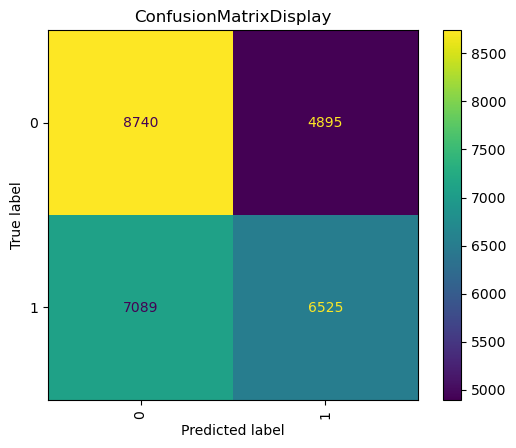

In [265]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title(f'ConfusionMatrixDisplay')
plt.xticks(rotation=90)
plt.show()

### Случайный лес

In [131]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=88)
rf_model.fit(X_train, y_train)

# Прогнозирование на тестовых данных
y_pred = rf_model.predict(X_test)

In [132]:
# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Вывод классификационного отчета
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5024

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.59      0.54     13635
           1       0.50      0.42      0.46     13614

    accuracy                           0.50     27249
   macro avg       0.50      0.50      0.50     27249
weighted avg       0.50      0.50      0.50     27249

